# Hierarchical Binominal Model: Rat Tumor Example

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.distributions.transforms as tr
import seaborn as sns
import theano.tensor as tt

from scipy.special import gammaln

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

This short tutorial demonstrates how to use PyMC3 to do inference for the rat tumour example found in chapter 5 of *Bayesian Data Analysis 3rd Edition*.  Readers should already be familliar with the PyMC3 API.

Suppose we are interested in the probability that a lab rat develops endometrial stromal polyps.  We have data from 71 previously performed trials and would like to use this data to perform inference.

The authors of BDA3 choose to model this problem heirarchically.  Let $y_i$ be the number of lab rats which develop endometrial stromal polyps out of a possible $n_i$.  We model the number rodents which develop endometrial stromal polyps as binomial

$$ y_i \sim \operatorname{Bin}(\theta_i;n_i)$$

allowing the probability of developing an endometrial stromal polyp (i.e. $\theta_i$) to be drawn from some population distribution.  For analytical tractability, we assume that $\theta_i$ has Beta distribution

$$ \theta_i \sim \operatorname{Beta}(\alpha, \beta)$$

We are free to specify a prior distribution for $\alpha, \beta$.  We choose a weakly informative prior distribution to reflect our ignorance about the true values of $\alpha, \beta$.  The authors of BDA3 choose the joint hyperprior for $\alpha, \beta$ to be

$$ p(\alpha, \beta) \propto (\alpha + \beta) ^{-5/2}$$

For more information, please see *Bayesian Data Analysis 3rd Edition* pg. 110.

## A Directly Computed Solution

Our joint posterior distribution is

$$p(\alpha,\beta,\theta \lvert y) 
\propto 
p(\alpha, \beta) 
p(\theta \lvert \alpha,\beta)
p(y \lvert \theta)$$

which can be rewritten in such a way so as to obtain the marginal posterior distribution for $\alpha$ and $\beta$, namely

$$ p(\alpha, \beta, \lvert y) = 
p(\alpha, \beta) 
\prod_{i = 1}^{N} \dfrac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)\Gamma(\beta)}
\dfrac{\Gamma(\alpha+y_i)\Gamma(\beta+n_i - y_i)}{\Gamma(\alpha+\beta+n_i)}$$


See BDA3 pg. 110 for a more information on the deriving the marginal posterior distribution. With a little determination, we can plot the marginal posterior and estimate the means of $\alpha$ and $\beta$ without having to resort to MCMC.  We will see, however, that this requires considerable effort.

The authors of BDA3 choose to plot the surfce under the paramterization $(\log(\alpha/\beta), \log(\alpha+\beta))$.  We do so as well.  Through the remainder of the example let $x = \log(\alpha/\beta)$ and $z = \log(\alpha+\beta)$.



In [3]:
# rat data (BDA3, p. 102)
# fmt: off
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])
# fmt: on

N = len(n)

In [4]:
# Compute on log scale because products turn to sums
def log_likelihood(alpha, beta, y, n):
    LL = 0

    # Summing over data
    for Y, N in zip(y, n):
        LL += (
            gammaln(alpha + beta)
            - gammaln(alpha)
            - gammaln(beta)
            + gammaln(alpha + Y)
            + gammaln(beta + N - Y)
            - gammaln(alpha + beta + N)
        )

    return LL


def log_prior(A, B):

    return -5 / 2 * np.log(A + B)


def trans_to_beta(x, y):

    return np.exp(y) / (np.exp(x) + 1)


def trans_to_alpha(x, y):

    return np.exp(x) * trans_to_beta(x, y)


# Create space for the parameterization in which we wish to plot
X, Z = np.meshgrid(np.arange(-2.3, -1.3, 0.01), np.arange(1, 5, 0.01))
param_space = np.c_[X.ravel(), Z.ravel()]
df = pd.DataFrame(param_space, columns=["X", "Z"])

# Transform the space back to alpha beta to compute the log-posterior
df["alpha"] = trans_to_alpha(df.X, df.Z)
df["beta"] = trans_to_beta(df.X, df.Z)

df["log_posterior"] = log_prior(df.alpha, df.beta) + log_likelihood(df.alpha, df.beta, y, n)
df["log_jacobian"] = np.log(df.alpha) + np.log(df.beta)

df["transformed"] = df.log_posterior + df.log_jacobian
df["exp_trans"] = np.exp(df.transformed - df.transformed.max())

# This will ensure the density is normalized
df["normed_exp_trans"] = df.exp_trans / df.exp_trans.sum()


surface = df.set_index(["X", "Z"]).exp_trans.unstack().values.T

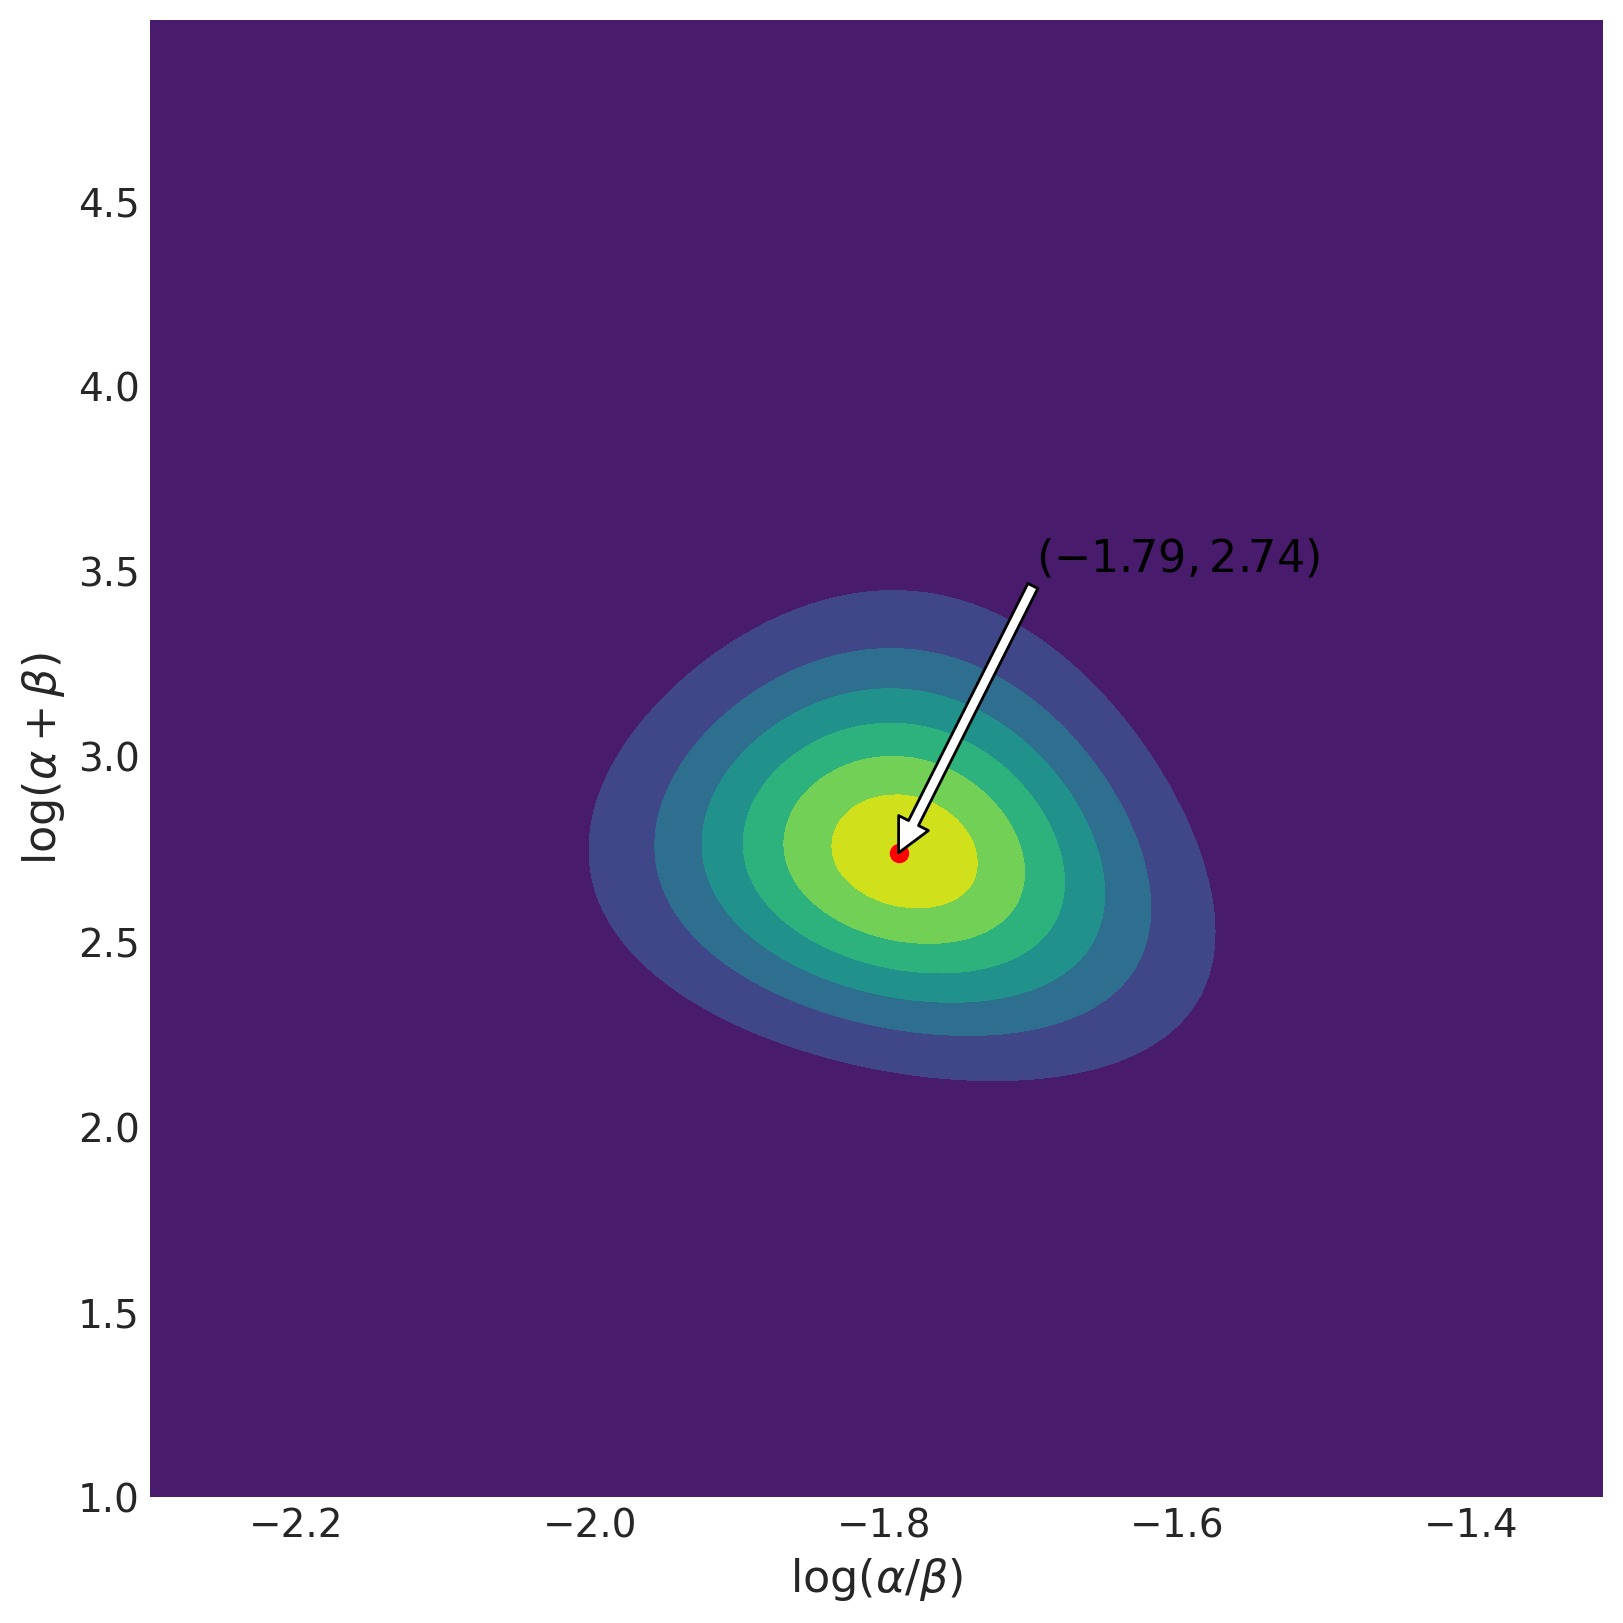

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(X, Z, surface)
ax.set_xlabel(r"$\log(\alpha/\beta)$", fontsize=16)
ax.set_ylabel(r"$\log(\alpha+\beta)$", fontsize=16)

ix_z, ix_x = np.unravel_index(np.argmax(surface, axis=None), surface.shape)
ax.scatter([X[0, ix_x]], [Z[ix_z, 0]], color="red")

text = r"$({a},{b})$".format(a=np.round(X[0, ix_x], 2), b=np.round(Z[ix_z, 0], 2))

ax.annotate(
    text,
    xy=(X[0, ix_x], Z[ix_z, 0]),
    xytext=(-1.6, 3.5),
    ha="center",
    fontsize=16,
    color="black",
    arrowprops={"facecolor": "white"},
);

The plot shows that the posterior is roughly symetric about the mode (-1.79, 2.74).  This corresponds to $\alpha = 2.21$ and $\beta = 13.27$. We can compute the marginal means as the authors of BDA3 do, using

$$ \operatorname{E}(\alpha \lvert y) \text{   is estimated by   }
\sum_{x,z} \alpha p(x,z\lvert y) $$

$$ \operatorname{E}(\beta \lvert y) \text{   is estimated by   }
\sum_{x,z} \beta p(x,z\lvert y) $$

In [6]:
# Estimated mean of alpha
(df.alpha * df.normed_exp_trans).sum().round(3)

2.403

In [7]:
# Estimated mean of beta
(df.beta * df.normed_exp_trans).sum().round(3)

14.319

## Computing the Posterior using PyMC3

Computing the marginal posterior directly is a lot of work, and is not always possible for sufficiently complex models. 

On the other hand, creating heirarchichal models in pymc3 is simple.  We can use the samples obtained from the posterior to estimate the means of $\alpha$ and $\beta$.



In [8]:
coords = {
    "obs_id": np.arange(N),
    "param": ["alpha", "beta"],
}

In [9]:
def logp_ab(value):
    """ prior density"""
    return tt.log(tt.pow(tt.sum(value), -5 / 2))


with pm.Model(coords=coords) as model:
    # Uninformative prior for alpha and beta
    n_val = pm.Data("n_val", n)
    ab = pm.HalfNormal("ab", sigma=10, dims="param")
    pm.Potential("p(a, b)", logp_ab(ab))

    X = pm.Deterministic("X", tt.log(ab[0] / ab[1]))
    Z = pm.Deterministic("Z", tt.log(tt.sum(ab)))

    theta = pm.Beta("theta", alpha=ab[0], beta=ab[1], dims="obs_id")

    p = pm.Binomial("y", p=theta, observed=y, n=n_val)
    trace = pm.sample(draws=1000, tune=2000, target_accept=0.95, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, ab]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'ab\nalpha'}>,
        <AxesSubplot:title={'center':'ab\nalpha'}>],
       [<AxesSubplot:title={'center':'ab\nbeta'}>,
        <AxesSubplot:title={'center':'ab\nbeta'}>],
       [<AxesSubplot:title={'center':'X'}>,
        <AxesSubplot:title={'center':'X'}>],
       [<AxesSubplot:title={'center':'Z'}>,
        <AxesSubplot:title={'center':'Z'}>]], dtype=object)

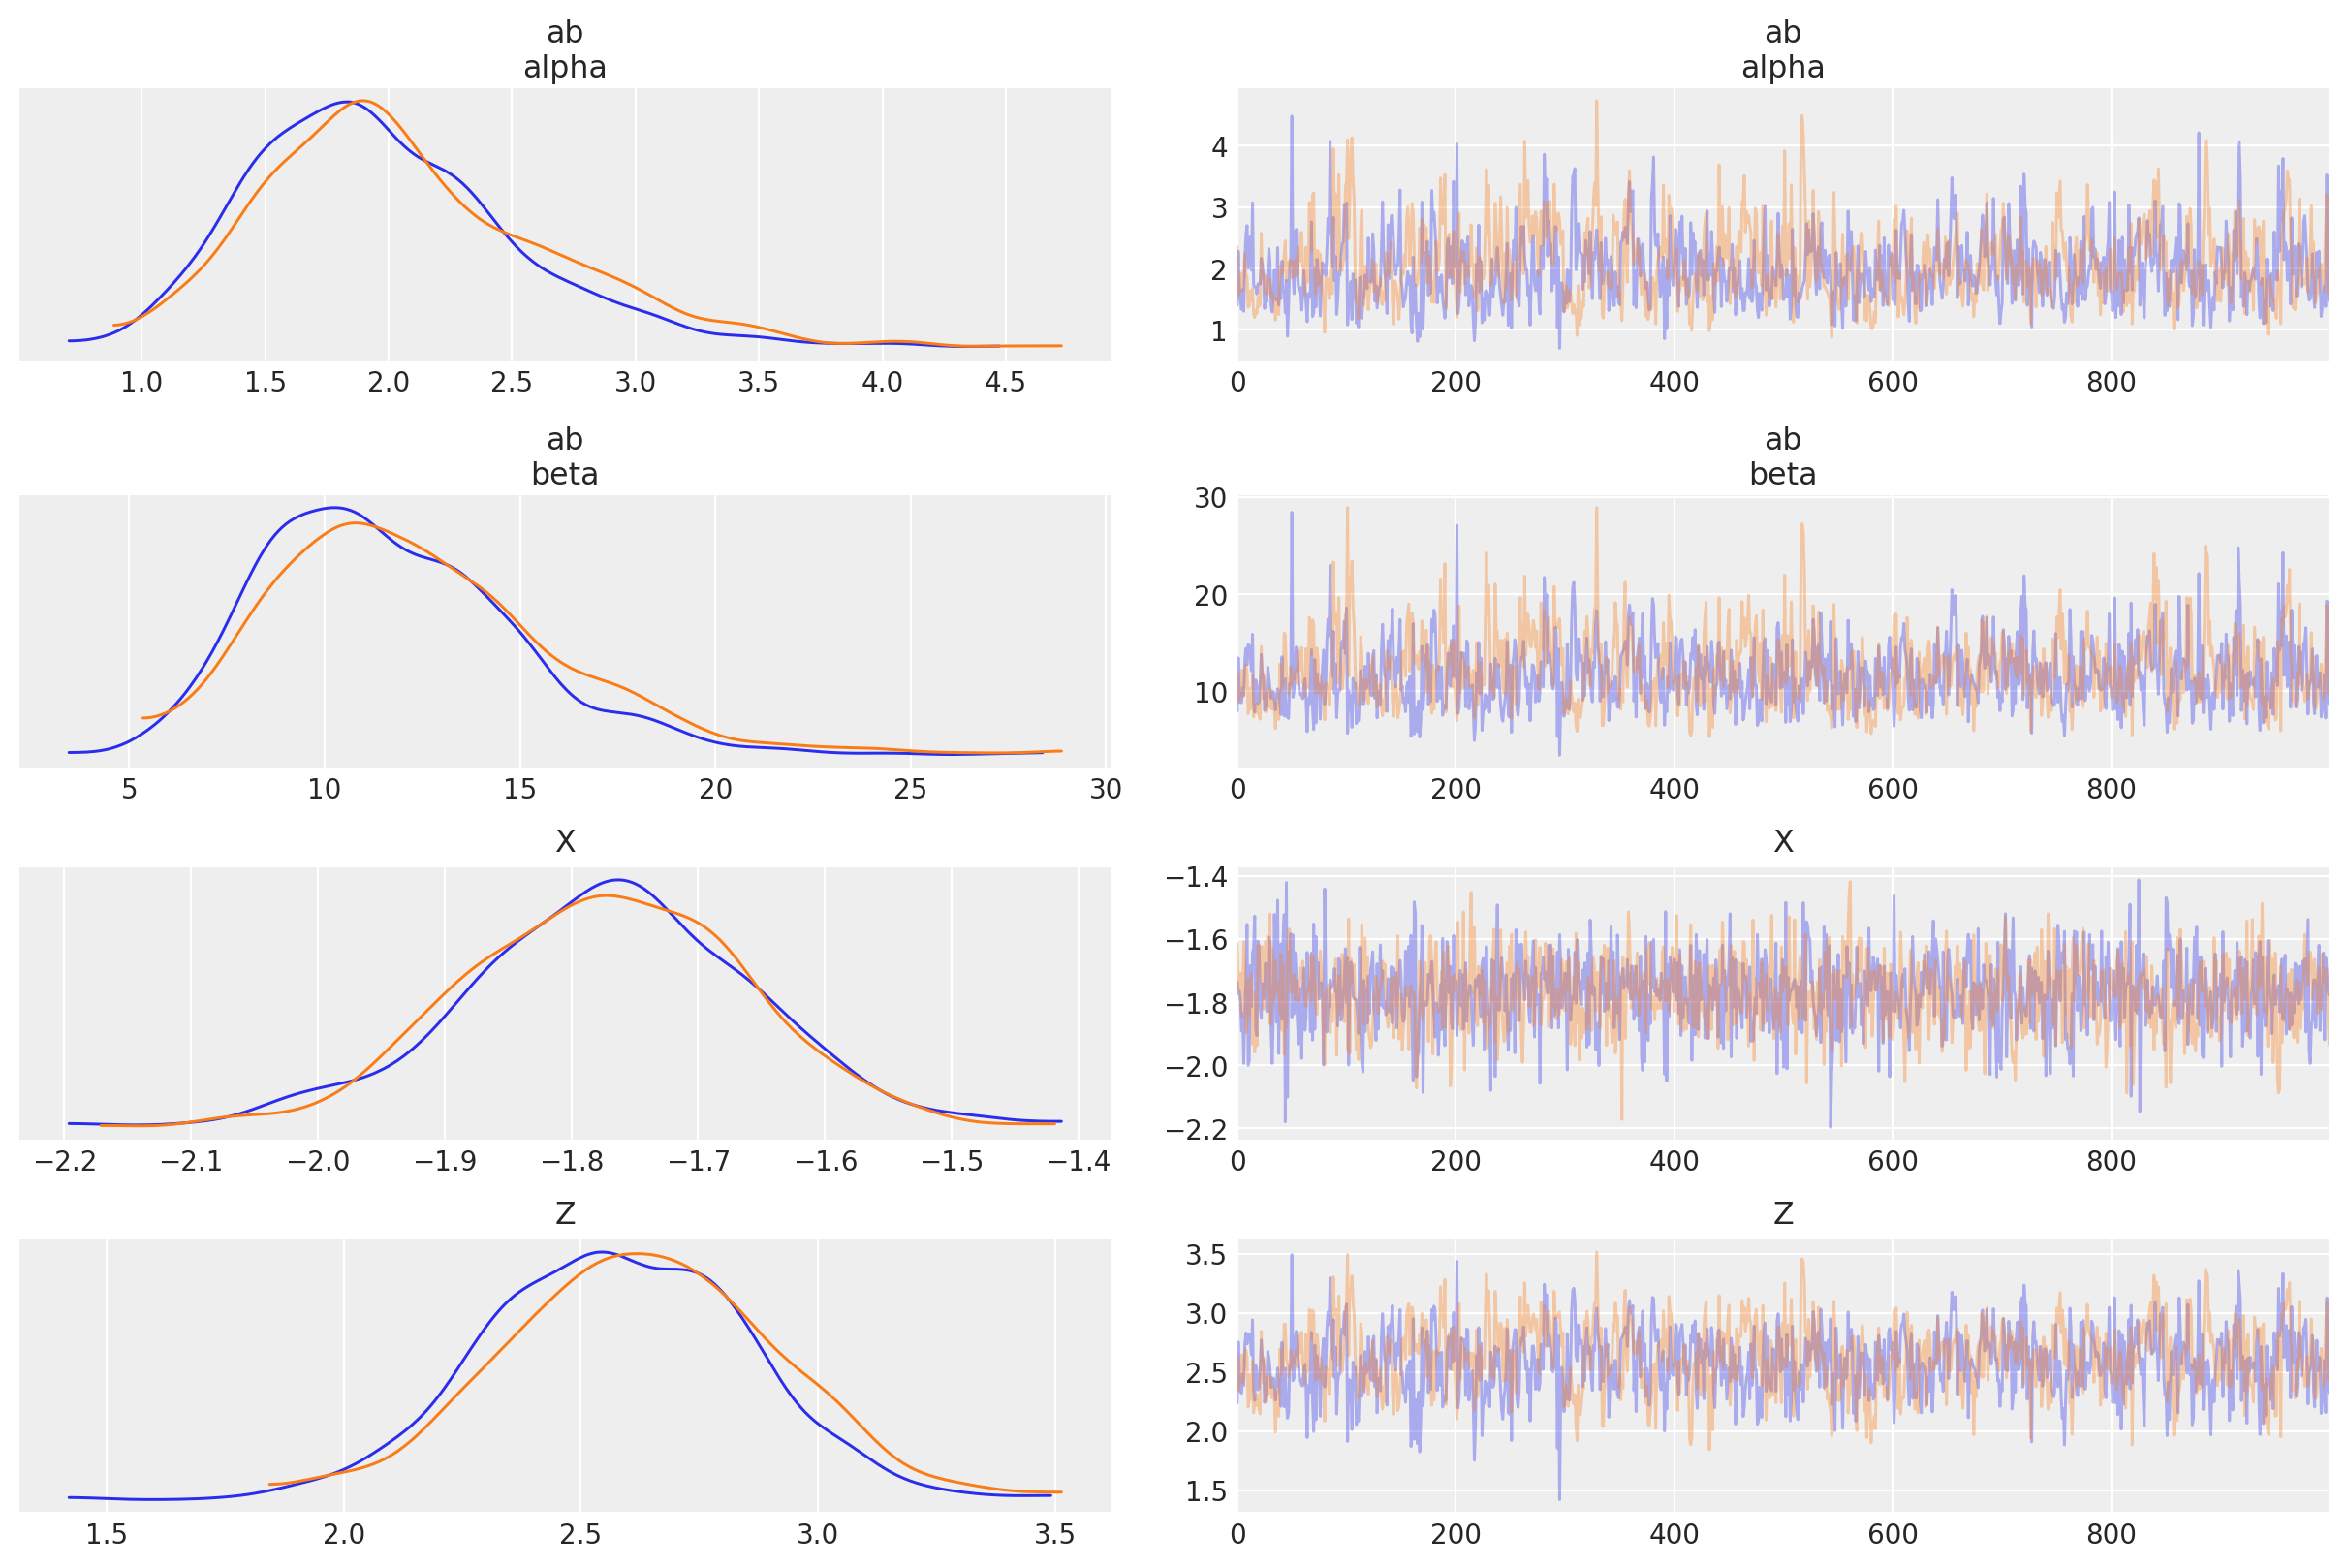

In [10]:
# Check the trace. Looks good!
az.plot_trace(trace, var_names=["ab", "X", "Z"], compact=False)

We can plot a kernel density estimate for $x$ and $y$. It looks rather similar to our countour plot made from the analytic marginal posterior density.  That's a good sign, and required far less effort.

<AxesSubplot:xlabel='X', ylabel='Z'>

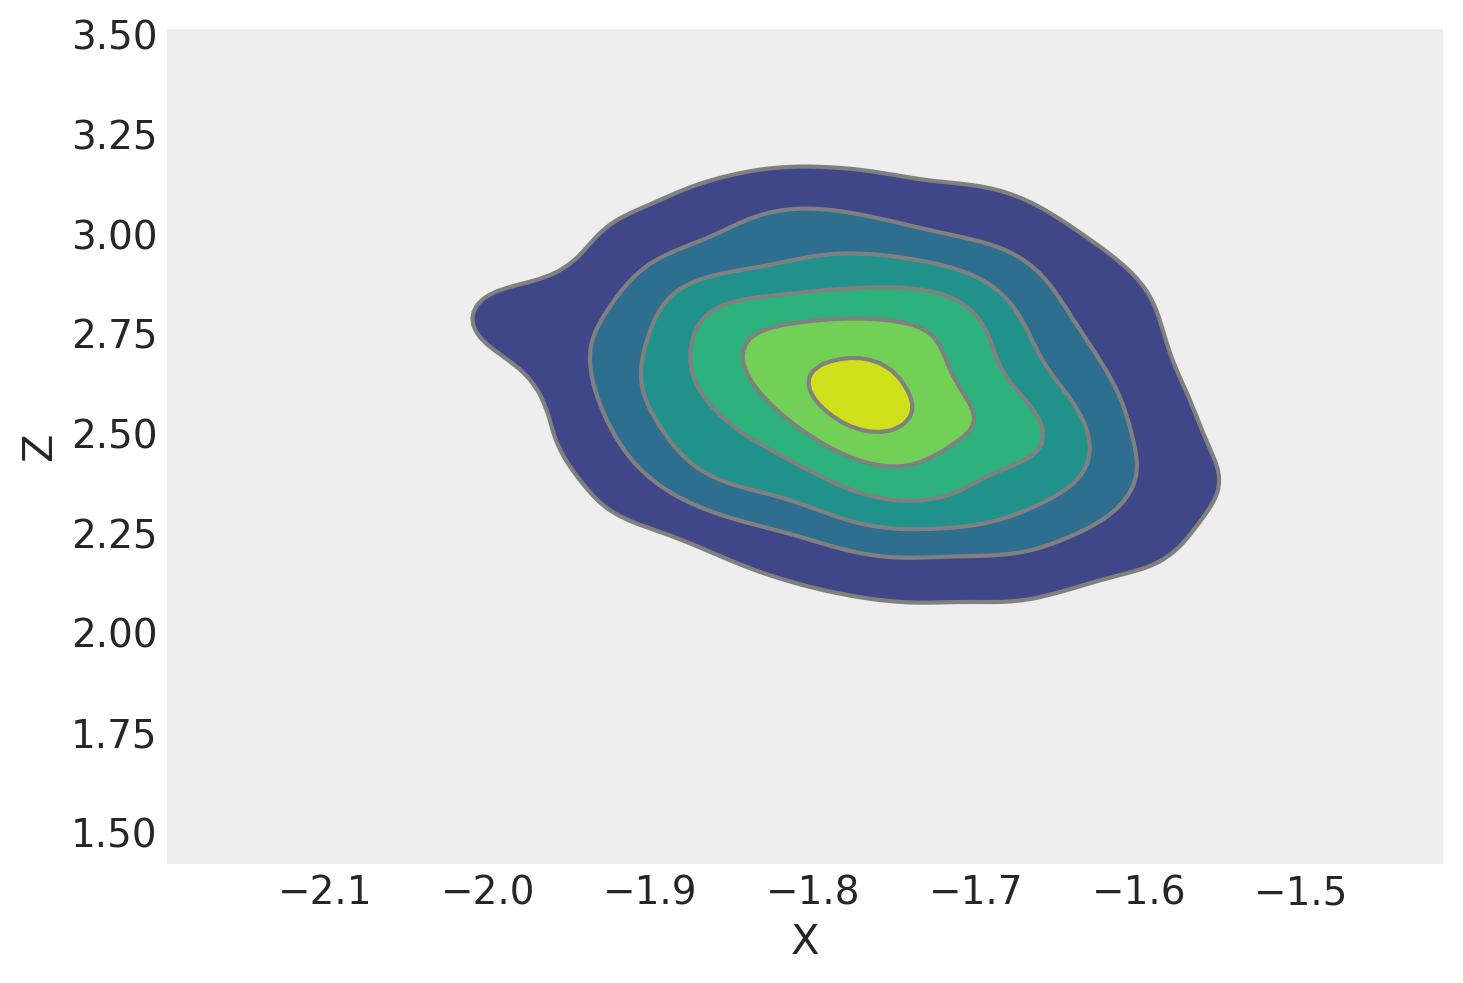

In [11]:
az.plot_pair(trace, var_names=["X", "Z"], kind="kde")

From here, we could use the trace to compute the mean of the distribution.

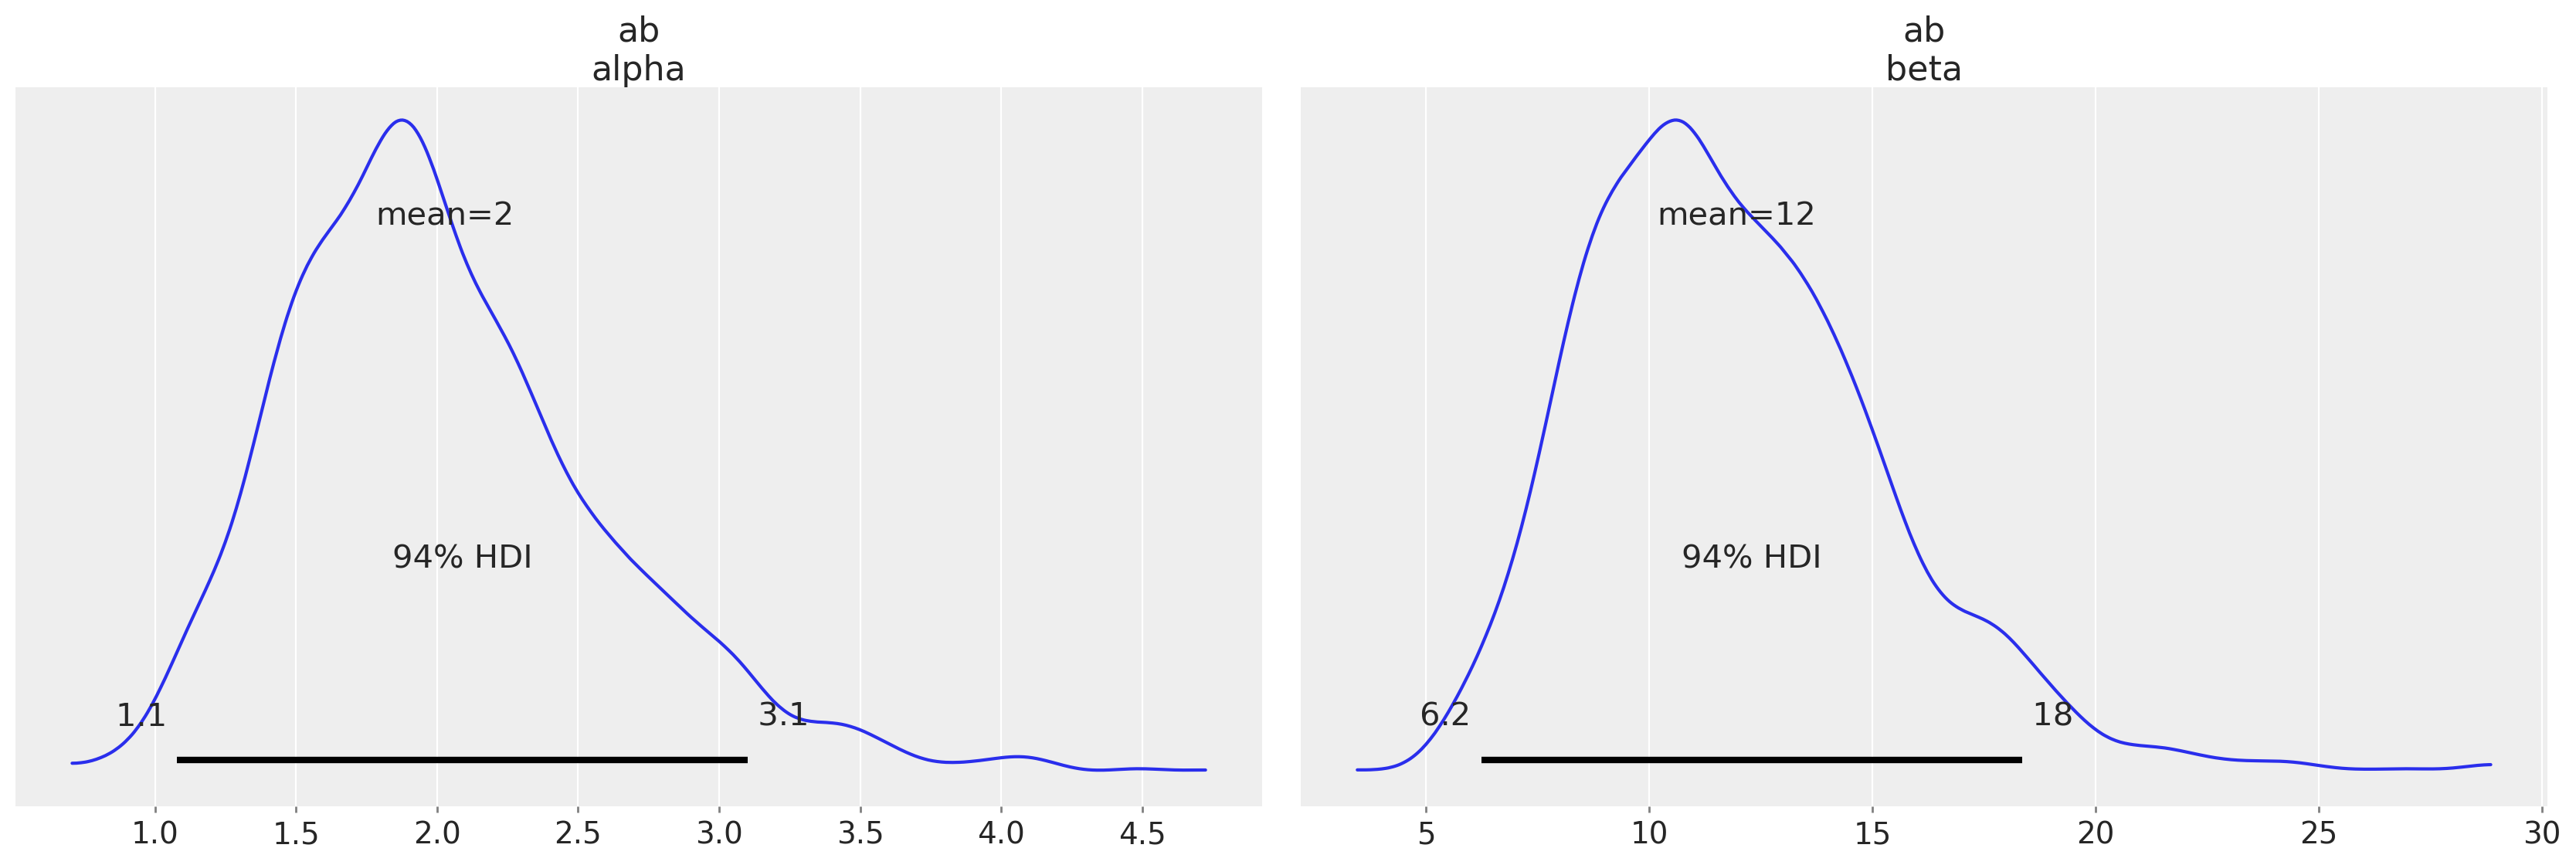

In [12]:
az.plot_posterior(trace, var_names=["ab"]);

In [13]:
# estimate the means from the samples
trace.posterior["ab"].mean(("chain", "draw"))

<xarray.DataArray 'ab' (param: 2)>
array([ 2.02723949, 11.95169965])
Coordinates:
  * param    (param) <U5 'alpha' 'beta'

## Conclusion

Analytically calculating statistics for posterior distributions is difficult if not impossible for some models.  Pymc3 provides an easy way drawing samples from your model's posterior with only a few lines of code.  Here, we used pymc3 to obtain estimates of the posterior mean for the rat tumor example in chapter 5 of BDA3. The estimates obtained from pymc3 are encouragingly close to the estimates obtained from the analytical posterior density.

## References

1. Gelman, Andrew, et al. *Bayesian Data Analysis*. CRC Press, 2013.

Authors: Demetri Pananos, Junpeng Lao

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Apr 24 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

arviz     : 0.11.0
numpy     : 1.20.0
pandas    : 1.2.1
matplotlib: None
pymc3     : 3.11.0
theano    : 1.1.2
seaborn   : 0.11.1

Watermark: 2.1.0

